<a></a>

# Model Explainability
Demostrating explainability using differnet methods for a resnet18 timm pretained model

*Note*: This code runs for the below methods for all images present in the folder "images"

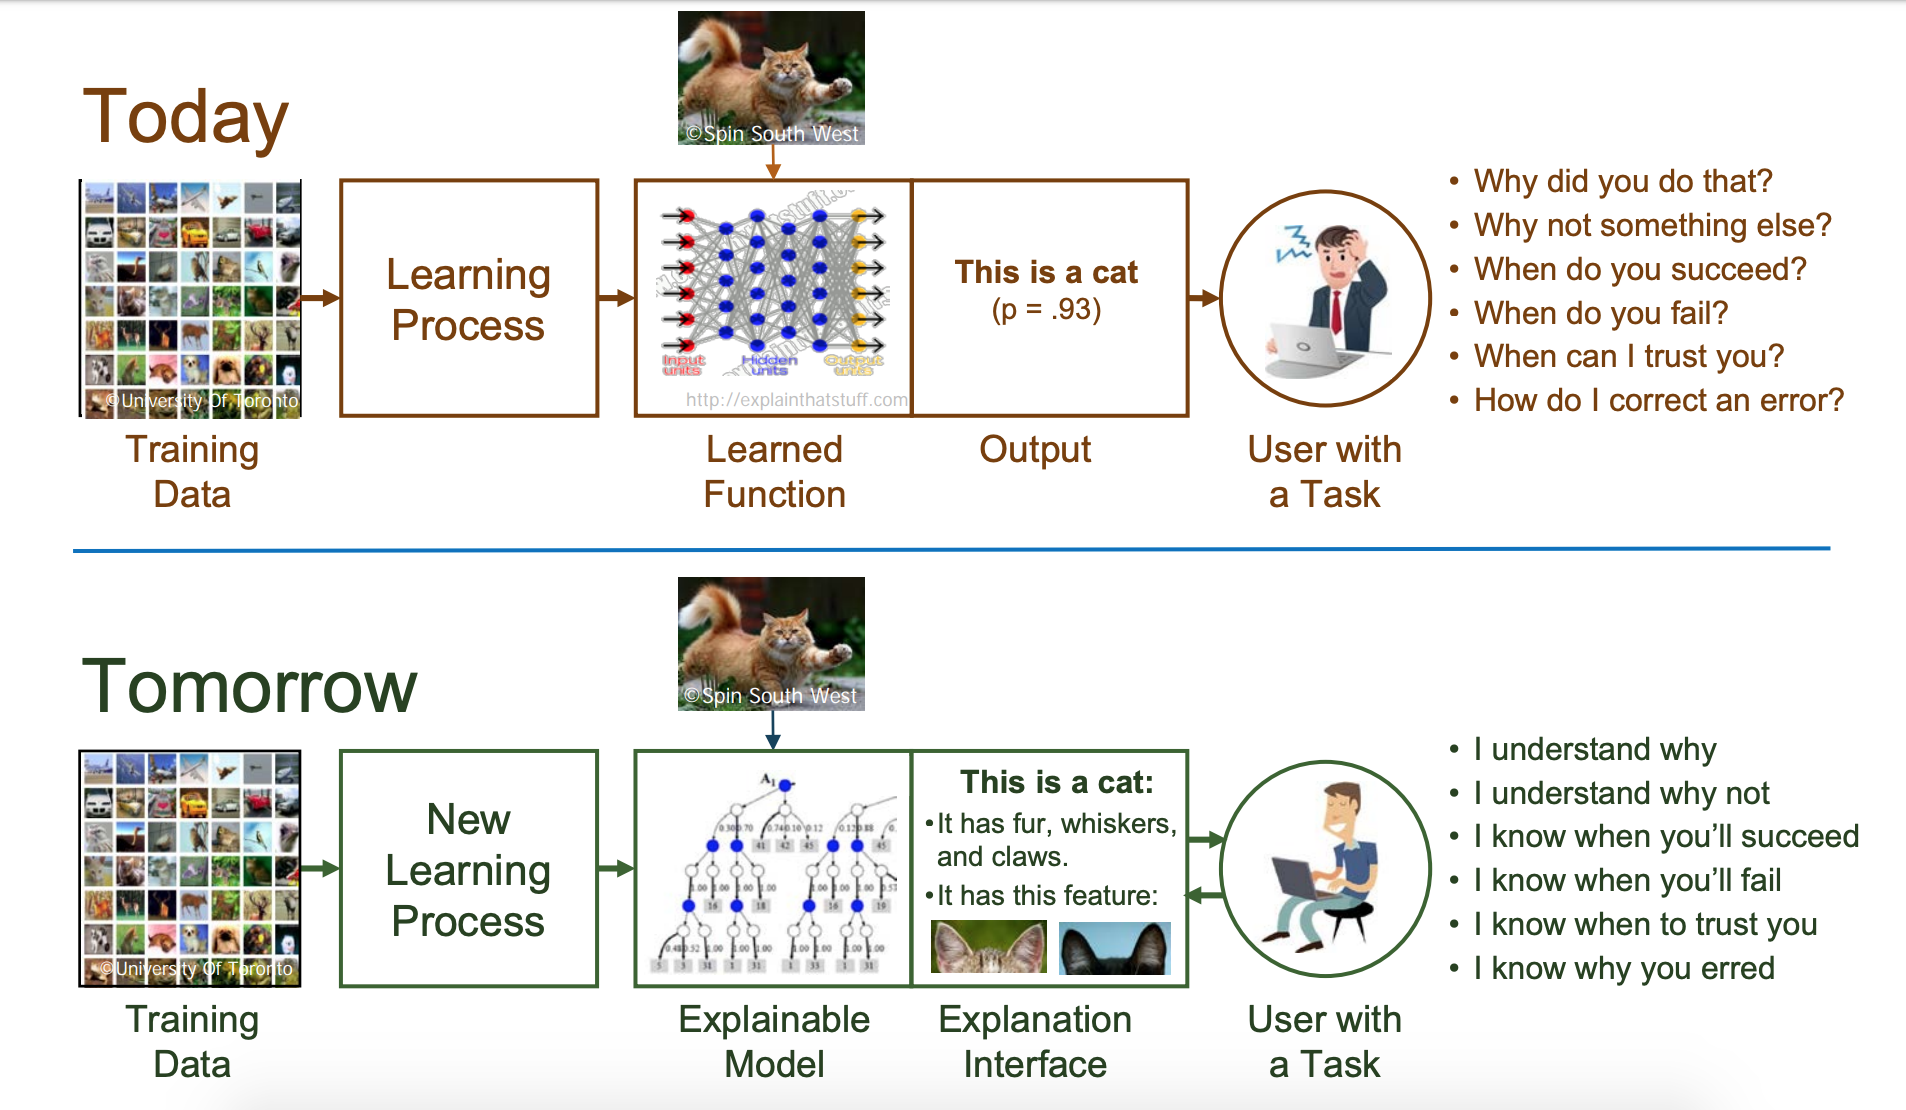

## Objective: Model Explanation with
1. IG
2. IG w/ Noise Tunnel
3. Saliency
4. Occlusion
5. SHAP
6. GradCAM
7. GradCAM++

In [1]:
# Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
from google.colab import drive
drive.mount("/content/gdrive")
gdrivepath="/content/gdrive/My Drive/EMLO2/S07_Main/"
import os 
os.chdir(gdrivepath)
!pwd
!ls

Mounted at /content/gdrive
/content/gdrive/My Drive/EMLO2/S07_Main
explain.py	      s07_1_explain.ipynb
imagenet_classes.txt  s07_2_explain_Adveserial_Attacks.ipynb
images		      s07_3_robustness.ipynb
output		      setup.py
requirements.txt


In [2]:
%pip install captum timm shap grad-cam --quiet

     |████████████████████████████████| 1.4 MB 38.9 MB/s 
     |████████████████████████████████| 549 kB 61.4 MB/s 
     |████████████████████████████████| 575 kB 82.2 MB/s 
     |████████████████████████████████| 7.8 MB 33.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 182 kB 83.9 MB/s 


In [3]:
import timm
import urllib
import torch

import numpy as np

import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image

from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt

In [4]:
import os

In [5]:
device = torch.device("cuda")
#device = torch.device("cpu")

In [6]:
# Download human-readable labels for ImageNet.
# get the classnames
url, filename = (
    "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
    "imagenet_classes.txt",
)
urllib.request.urlretrieve(url, filename)
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]


## Resnet-18


In [7]:
model = timm.create_model("resnet18", pretrained=True) 
model.eval()
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [8]:
transform = T.Compose([
    # T.Resize((299, 299)),
    T.Resize((224, 224)),
    # T.Resize((384, 384)),
    # T.CenterCrop(224),
    T.ToTensor()
])

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

transform_normalize = T.Normalize(
     mean=mean,
     std=std
)
inv_transform= T.Compose([
    T.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
])


In [9]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import Saliency
from captum.attr import visualization as viz

In [10]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

Define a color map for black to white

In [11]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

In [12]:
explainability_methods = ['ig', 'nt', 'grad_shap', 'saliency', 'occ', 'gcp', 'gc']

In [13]:
def grad_cam(img_tensor, plus=False):
    target_layers = [model.layer4[-1]]
    targets = [ClassifierOutputTarget(281)]

    if plus:
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
    else:
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)
    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    rgb_img = inv_transform(img_tensor).cpu().squeeze().permute(1, 2, 0).detach().numpy()
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    return(visualization)

In [32]:
def explainable_out(img_path, method='ig'):
    #out_img_path = img_path[:img_path.rfind(".")] + "_" + method + ".jpg"

    path_list = img_path.split(os.sep)
    filname=path_list[1]
    #print (path_list)
    out_img_path = "output_1/"+filname[:filname.rfind(".")] + "_" + method + ".jpg"


    #print(out_img_path)
    img = Image.open(img_path)
    transformed_img = transform(img)
    img_tensor = transform_normalize(transformed_img)
    img_tensor = img_tensor.unsqueeze(0)

    img_tensor = img_tensor.to(device)
    output = model(img_tensor)

    # output_sig = torch.sigmoid(output)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = categories[pred_label_idx.item()]
    print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

    original_image = np.transpose((img_tensor.squeeze(0).cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    print("*---------------------- " + method + " ----------------------*" )
    if method == "gc":
        plt_fig = grad_cam(img_tensor)
        # plt_fig.savefig(out_img_path)
        return plt_fig
    if method == "gcp":
        plt_fig = grad_cam(img_tensor, True)
        # plt_fig.savefig(out_img_path)
        return plt_fig

    heat_map_method = "heat_map"
    sign="positive"
    cmap=default_cmap

    if method == "ig":
        integrated_gradients = IntegratedGradients(model)
        attributions = integrated_gradients.attribute(img_tensor, target=pred_label_idx, n_steps=200)

        del integrated_gradients
        
    if method == 'nt':
        print("Noise Tunnel")
        integrated_gradients = IntegratedGradients(model)
        noise_tunnel = NoiseTunnel(integrated_gradients)

        attributions = noise_tunnel.attribute(img_tensor, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
        del integrated_gradients
        del noise_tunnel

    if method == 'grad_shap':
        torch.manual_seed(0)
        np.random.seed(0)

        gradient_shap = GradientShap(model)

        # Defining baseline distribution of images
        rand_img_dist = torch.cat([img_tensor * 0, img_tensor * 1])

        attributions = gradient_shap.attribute(img_tensor,
                                                n_samples=50,
                                                stdevs=0.0001,
                                                baselines=rand_img_dist,
                                                target=pred_label_idx)
        del gradient_shap
        del rand_img_dist

    if method == 'occ':
        occlusion = Occlusion(model)
        attributions = occlusion.attribute(img_tensor,
                                            strides = (3, 8, 8),
                                            target=pred_label_idx,
                                            sliding_window_shapes=(3,15, 15),
                                            baselines=0)
        heat_map_method = "blended_heat_map"
        sign="absolute_value"
        cmap=None
        del occlusion

    if method == 'saliency':
        saliency = Saliency(model)
        attributions = saliency.attribute(img_tensor, target=pred_label_idx)
        heat_map_method = "blended_heat_map"
        sign="absolute_value"
        cmap=None
        del saliency
        

    plt_fig, _ = viz.visualize_image_attr(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 original_image, method=heat_map_method,
                                 cmap=cmap,
                                 sign=sign,
                        #   show_colorbar=True, title="Overlayed Gradient Magnitudes"
                          )
   
    del attributions
    print(out_img_path)
    plt_fig.savefig(out_img_path)
    print("*---------------------------------------------------*" )    
    return plt_fig

In [33]:
for img in os.listdir('images'):
    img_path = "images/"+img
    for meth in explainability_methods:
        explainable_out(img_path, meth)

Output hidden; open in https://colab.research.google.com to view.